In [1]:
%cd ..

/home/zengyun1/gnn/TMP_NN


/home/zengyun1/App/miniconda3/envs/gnn/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pickle
with open('Dataset/Myers-Saito_cyclization.pkl', 'rb') as file:
    data_list = pickle.load(file)

In [3]:
import numpy as np

In [5]:
print(len(data_list))
print(data_list[0])

716
Data(x=[26, 48], edge_index=[2, 50], edge_attr=[50, 7], y=[1], pos=[26, 3], global_features=[13], x3d=[26, 8, 8, 8], x2d=[26, 10, 20], path='MSC_0000_std', fragment=[3])


In [6]:
y = np.array([float(G.y) for G in data_list])

In [7]:
from torch.utils.data import TensorDataset, DataLoader,random_split

def get_datalist(data_list):
    data_size = len(data_list)
    
    x3d_total = torch.empty(data_size, atom_num, 8, 8, 8)  
    x2d_total = torch.empty(data_size, atom_num, 10, 20)
    x1d_total = torch.empty(data_size, atom_num, 23)
    x0d_total = torch.empty(data_size, 13)  # 
    y_total = torch.empty(data_size, 1)  
    for idx, G in enumerate(data_list):
        x3d_total[idx] = G.x3d[atom_list, :, :, :]
        x2d_total[idx] = G.x2d[atom_list, :, :]
        x1d_total[idx] = G.x[atom_list, :23]
        x0d_total[idx] = G.global_features

        # x0d_total[idx] = torch.cat((G.global_features[:1], G.global_features[3:]))
        y_total[idx] = G.y

    dataset = TensorDataset(x3d_total, x2d_total, x1d_total, x0d_total, y_total)
    return dataset

In [ ]:
import torch
atom_list = [0,1,2,3,4,5,6]
atom_num = len(atom_list)

In [13]:
from torch.utils.data import TensorDataset, DataLoader,random_split

def get_datalist(data_list):
    data_size = len(data_list)
    
    x3d_total = torch.empty(data_size, atom_num, 8, 8, 8)  
    x2d_total = torch.empty(data_size, atom_num, 10, 20)
    x1d_total = torch.empty(data_size, atom_num, 23)
    x0d_total = torch.empty(data_size, 13)  # 
    y_total = torch.empty(data_size, 1)  
    for idx, G in enumerate(data_list):
        x3d_total[idx] = G.x3d[atom_list, :, :, :]
        x2d_total[idx] = G.x2d[atom_list, :, :]
        x1d_total[idx] = G.x[atom_list, :23]
        x0d_total[idx] = G.global_features

        # x0d_total[idx] = torch.cat((G.global_features[:1], G.global_features[3:]))
        y_total[idx] = G.y

    dataset = TensorDataset(x3d_total, x2d_total, x1d_total, x0d_total, y_total)
    return dataset

In [16]:
import torch
atom_list = [0,1,2,3,4,5,6]
atom_num = len(atom_list)

Training Values:
Mean: 22.630098
Median: 23.144081
Standard Deviation: 2.340824

Test Values:
Mean: 22.23037
Median: 23.019524
Standard Deviation: 2.5812745


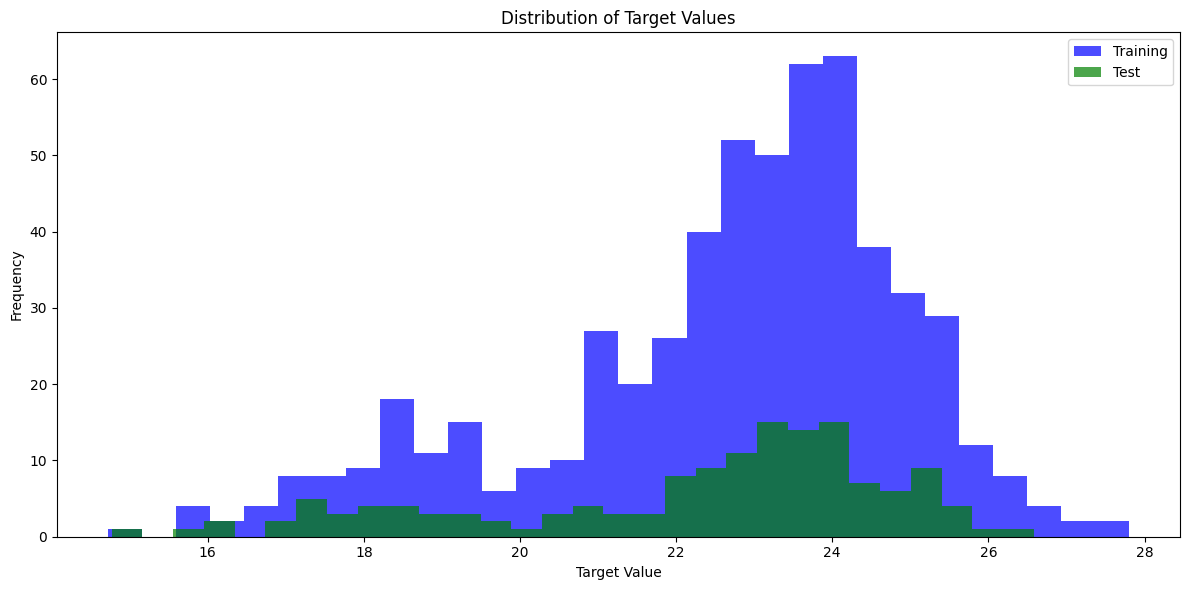

In [53]:
dataset = get_datalist(data_list)

train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size

torch.manual_seed(2025)
# 
# Randomly partition the data set
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

train_values = []

for _, _, _, _, targets in train_dataloader:
    train_values.append(targets.numpy())
train_values = np.concatenate(train_values)

test_values = []

for _, _, _, _, targets in test_dataloader:
    test_values.append(targets.numpy())
test_values = np.concatenate(test_values)

print("Training Values:")
print("Mean:", np.mean(train_values))
print("Median:", np.median(train_values))
print("Standard Deviation:", np.std(train_values))

print("\nTest Values:")
print("Mean:", np.mean(test_values))
print("Median:", np.median(test_values))
print("Standard Deviation:", np.std(test_values))

plt.figure(figsize=(12, 6))

plt.hist(train_values, bins=30, color='blue', alpha=0.7, label='Training')

plt.hist(test_values, bins=30, color='green', alpha=0.7, label='Test')
plt.legend()

plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [18]:
import numpy as np

x3d_list = []
x2d_list = []
x1d_list = []
y_list = []

for x3d_total, x2d_total, x1d_total, x0d_total, y_total in dataset:
    x3d_list.append(x3d_total.numpy())
    x2d_list.append(x2d_total.numpy())
    x1d_list.append(x1d_total.numpy())
    y_list.append(y_total.numpy())

x3d_array = np.array(x3d_list)
x2d_array = np.array(x2d_list)
x1d_array = np.array(x1d_list)
y_array = np.array(y_list)

print("x3d_array shape:", x3d_array.shape)
print("x2d_array shape:", x2d_array.shape)
print("x1d_array shape:", x1d_array.shape)
print("y_array shape:", y_array.shape)


x3d_array shape: (716, 7, 8, 8, 8)
x2d_array shape: (716, 7, 10, 20)
x1d_array shape: (716, 7, 23)
y_array shape: (716, 1)


# model

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler


In [39]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, key_dim, value_dim, hidden_dim):
        super(CrossAttention, self).__init__()
        self.query_projection = nn.Linear(query_dim, hidden_dim)
        self.key_projection = nn.Linear(key_dim, hidden_dim)
        self.value_projection = nn.Linear(value_dim, hidden_dim)
        self.hidden_dim = hidden_dim
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, query, key, value):
        query_projected = self.layer_norm(self.query_projection(query))
        key_projected = self.layer_norm(self.key_projection(key))
        value_projected = self.layer_norm(self.value_projection(value))

        # Calculate attention scores
        attention_scores = torch.matmul(query_projected, key_projected.transpose(-2, -1))
        attention_scores = attention_scores / (self.hidden_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply the attention weights to the values
        attention_output = torch.matmul(attention_weights, value_projected)
        return attention_output
    
class WeightedConcat(nn.Module):
    def __init__(self, num_inputs):
        super(WeightedConcat, self).__init__()
        self.weights = nn.Parameter(torch.ones(num_inputs, requires_grad=True))

    def forward(self, *inputs):
        weighted_inputs = [w * x for w, x in zip(self.weights, inputs)]
        return torch.cat(weighted_inputs, dim=1)
    
class MultimodalMoleculeNet(nn.Module):
    def __init__(self, in_channels_3d=1, in_channels_2d=1, in_features_rnn=23, 
                 mid_channels=16, out_channels=32, hidden_size_rnn=128, dropout_rate=0.3):
        super(MultimodalMoleculeNet, self).__init__()
        
        # 3D CNN layers
        self.conv3d_1 = nn.Conv3d(in_channels_3d, mid_channels, kernel_size=2)
        self.bn3d_1 = nn.BatchNorm3d(mid_channels)
        self.pool3d = nn.MaxPool3d(2)
        self.conv3d_2 = nn.Conv3d(mid_channels, out_channels, kernel_size=2)
        self.bn3d_2 = nn.BatchNorm3d(out_channels)

        # 2D CNN layers
        self.conv2d_1 = nn.Conv2d(in_channels_2d, mid_channels, kernel_size=2)
        self.bn2d_1 = nn.BatchNorm2d(mid_channels)
        self.pool2d = nn.MaxPool2d(3)
        self.conv2d_2 = nn.Conv2d(mid_channels, out_channels, kernel_size=2)
        self.bn2d_2 = nn.BatchNorm2d(out_channels)
        
        self.attention3d_2d = CrossAttention(query_dim=512, key_dim=200, value_dim=200, hidden_dim=128)
        self.attention1d_2d = CrossAttention(query_dim=23, key_dim=200, value_dim=200, hidden_dim=64)

        # RNN layer
        self.lstm_3d = nn.LSTM(input_size=256, hidden_size=hidden_size_rnn, num_layers=1, batch_first=True)
        self.lstm_2d = nn.LSTM(input_size=32*10, hidden_size=hidden_size_rnn, num_layers=1, batch_first=True)
        self.lstm_rnn = nn.LSTM(input_size=in_features_rnn, hidden_size=hidden_size_rnn,dropout=0.0, num_layers=1, batch_first=True)

        self.lstm_rnn1 = nn.LSTM(input_size=64, hidden_size=hidden_size_rnn,dropout=0.2, num_layers=3, batch_first=True)
        self.lstm_rnn3 = nn.LSTM(input_size=128, hidden_size=hidden_size_rnn,dropout=0.5, num_layers=3, batch_first=True)
        self.weighted_concat = WeightedConcat(num_inputs=5)
        # Fully connected layers

        self.layers = nn.Sequential(

            nn.Linear(5 * hidden_size_rnn, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64),
            nn.Dropout(p=dropout_rate),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x_3d, x_2d, x_rnn):
        batch_size, num_atoms, d, h, w = x_3d.size()
        
        x3d_reshape = x_3d.view(batch_size,num_atoms, -1)
        x2d_reshape = x_2d.view(batch_size, num_atoms, -1)
        x3d_2d = self.attention3d_2d(x3d_reshape, x2d_reshape, x2d_reshape)
        x1d_2d = self.attention1d_2d(x_rnn, x2d_reshape, x2d_reshape)

        
        # 3D CNN branch
        x3d = x_3d.view(batch_size * num_atoms, 1, d, h, w)  # Flatten atomic dimension
        x3d = F.relu(self.bn3d_1(self.conv3d_1(x3d)))
        x3d = self.pool3d(x3d)
        x3d = F.relu(self.bn3d_2(self.conv3d_2(x3d)))

        x3d = x3d.view(batch_size, num_atoms, -1)  # Reshape to (batch_size, num_atoms, features)
        x3d, _ = self.lstm_3d(x3d)
        x3d = x3d[:, -1, :]  # Use the last RNN step output

        # 2D CNN branch
        batch_size, num_atoms, h, w = x_2d.size()
        x2d = x_2d.view(batch_size * num_atoms, 1, h, w)  # Flatten atomic dimension
        x2d = F.relu(self.bn2d_1(self.conv2d_1(x2d)))
        x2d = self.pool2d(x2d)
        x2d = F.relu(self.bn2d_2(self.conv2d_2(x2d)))

        x2d = x2d.view(batch_size, num_atoms, -1)  # Reshape to (batch_size, num_atoms, features)
        x2d, _ = self.lstm_2d(x2d)
        x2d = x2d[:, -1, :]  # Use the last RNN step output

        # RNN branch
        x_rnn, _ = self.lstm_rnn(x_rnn)
        x_rnn = x_rnn[:, -1, :]  # Use the last RNN step output
        
        x3d_2d, _ = self.lstm_rnn3(x3d_2d)
        x3d_2d = x3d_2d[:, -1, :]  # Use the last RNN step output 
        
        x1d_2d, _ = self.lstm_rnn1(x1d_2d)
        x1d_2d = x1d_2d[:, -1, :]  # Use the last RNN step output 
        # print(x1d_2d.shape,x3d_2d.shape)
        # Concatenate outputs from three branches
        x = self.weighted_concat(x3d, x2d, x_rnn, x3d_2d, x1d_2d)
        # x = torch.cat((x3d, x2d, x_rnn,x3d_2d,x1d_2d), dim=1)

        x = self.layers(x)
        return x


In [40]:
from tqdm import tqdm

In [54]:
model=MultimodalMoleculeNet().to(device)

from torch.optim.lr_scheduler import StepLR
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()


LR = 0.01

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)  # 定义优化器
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # 定义学习率调度器
num_epochs = 500

lr_list = []  # 列表来存储每个epoch的学习率
pbar = tqdm(range(num_epochs))

for epoch in pbar:
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:  # 假设我们只用x3d和targets进行训练
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(x3d,x2d,x1d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / (2 * len(train_dataloader)) 

    scheduler.step()
    current_lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_list.append(current_lr)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x3d, x2d, x1d, x0d, targets  in test_dataloader:
            x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
            outputs = model(x3d,x2d,x1d)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_dataloader)
    pbar.set_postfix(dict(Training=f"{avg_loss:.1f}", Validation=f"{avg_val_loss:.1f}"))



100%|███████████| 500/500 [05:47<00:00,  1.44it/s, Training=0.4, Validation=1.2]


In [55]:
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for x3d, x2d, x1d, x0d, targets  in train_dataloader:
        x3d, x2d, x1d, targets = x3d.to(device), x2d.to(device), x1d.to(device), targets.to(device)
        outputs = model(x3d,x2d,x1d)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

avg_val_loss = total_val_loss / len(train_dataloader)
avg_val_loss

0.10590755036618146

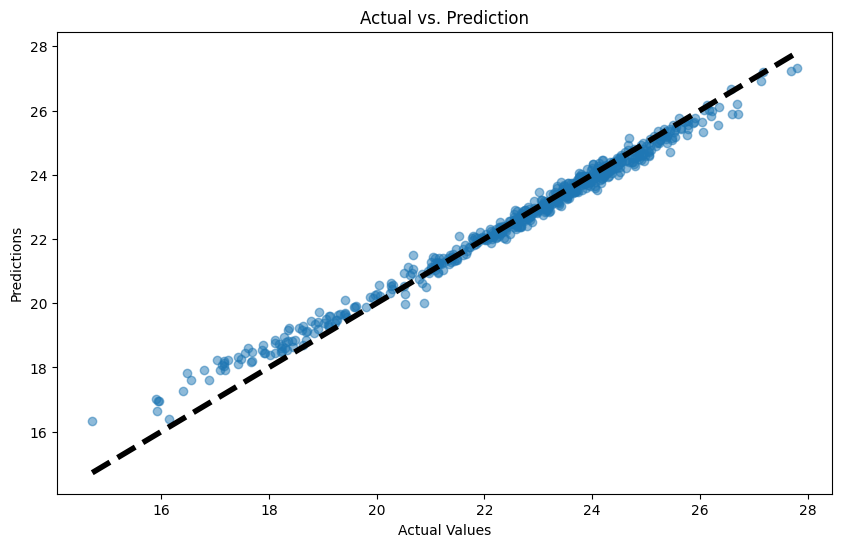

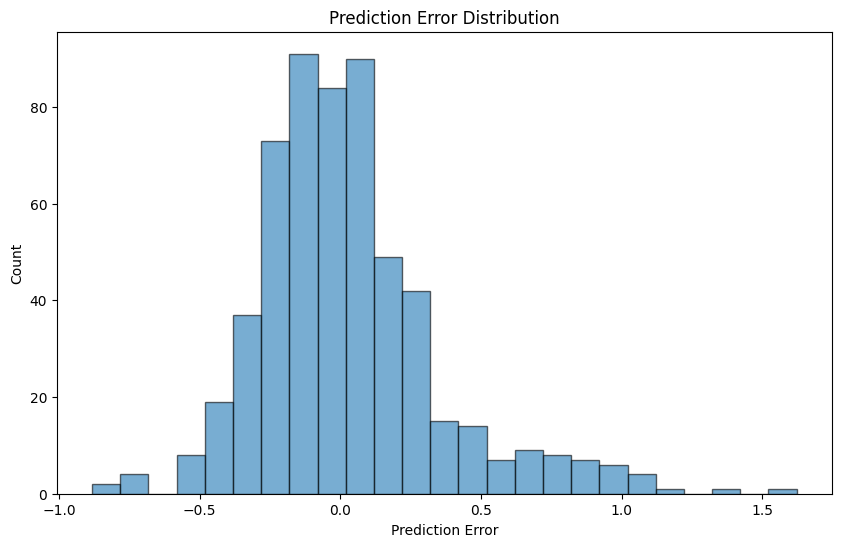

In [56]:
model.eval()  # 设置模型为评估模式
actuals = []
predictions = []

with torch.no_grad():
    for x3d,x2d,x1d,x0d, targets  in train_dataloader:
        x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)


        outputs = model(x3d,x2d,x1d)

        # 假设输出直接是预测值，对于分类问题可能需要转换（如使用softmax）
        actuals.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

# 转换为numpy数组
actuals = np.array(actuals)
predictions = np.array(predictions)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  # 绘制理想线
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual vs. Prediction')
plt.show()

# 绘制误差分布图
errors = predictions - actuals
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25, edgecolor='k', alpha=0.6)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()

In [57]:
def model_Performance(dataloader):
    model.eval() 
    actuals = []
    predictions = []
    
    with torch.no_grad():
        for x3d,x2d,x1d,x0d, targets  in dataloader:
            x3d,x2d,x1d,x0d, targets = x3d.to(device),x2d.to(device),x1d.to(device),x0d.to(device),targets.to(device)
    
    
            outputs = model(x3d,x2d,x1d)
            actuals.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())
    
    actuals = np.array(actuals)
    predictions = np.array(predictions)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title('Actual vs. Prediction')
    plt.show()
    
    errors = predictions - actuals
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=25, edgecolor='k', alpha=0.6)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Prediction Error Distribution')
    plt.show()


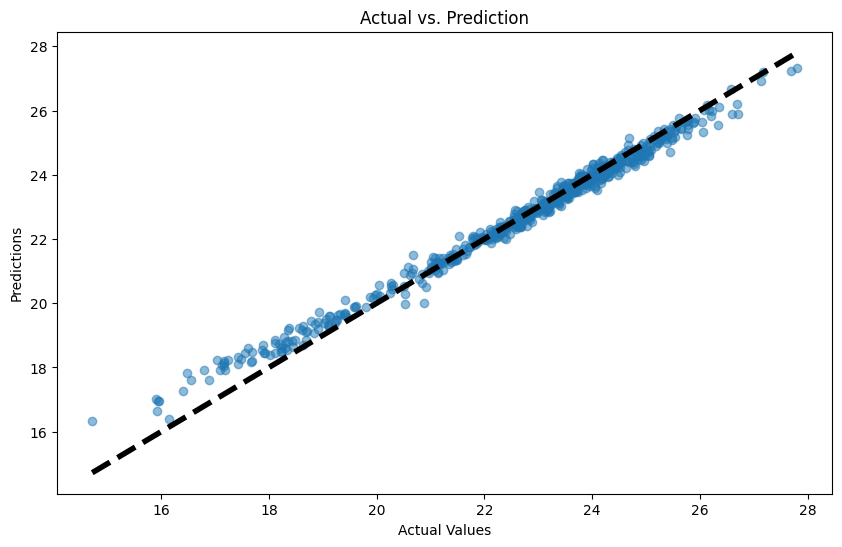

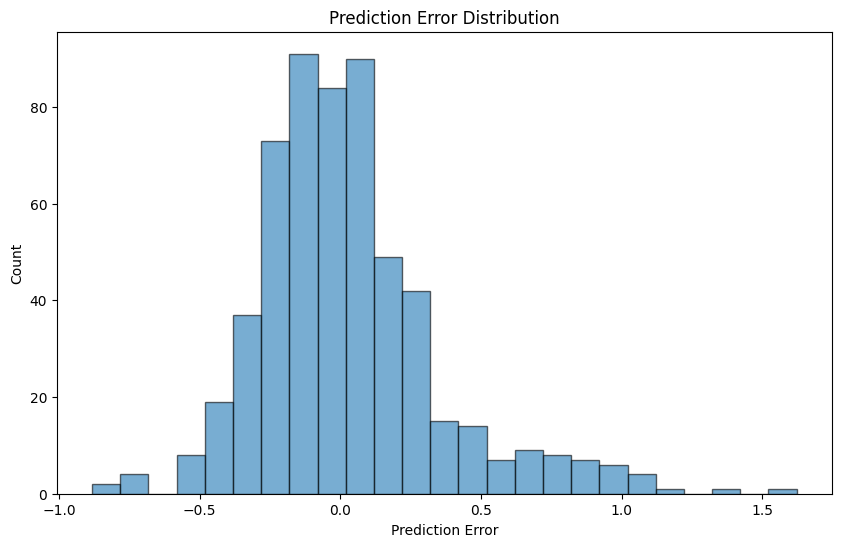

In [58]:
model_Performance(train_dataloader)

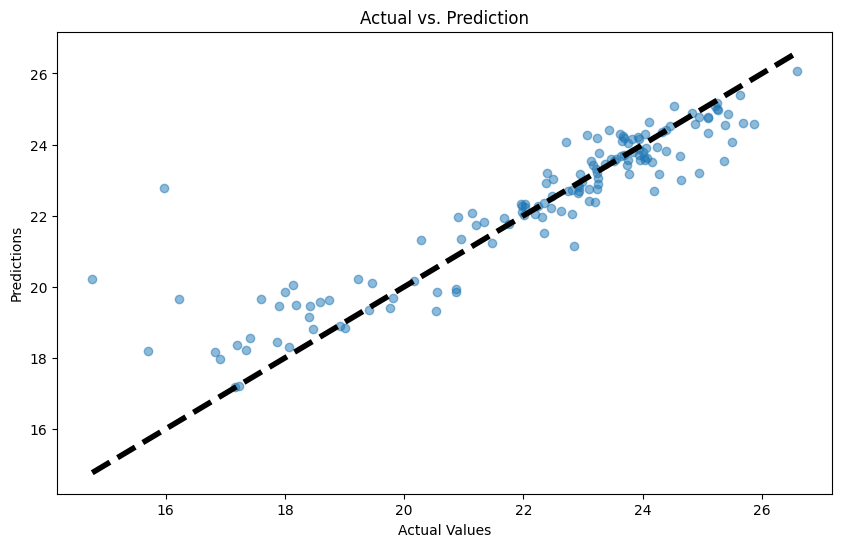

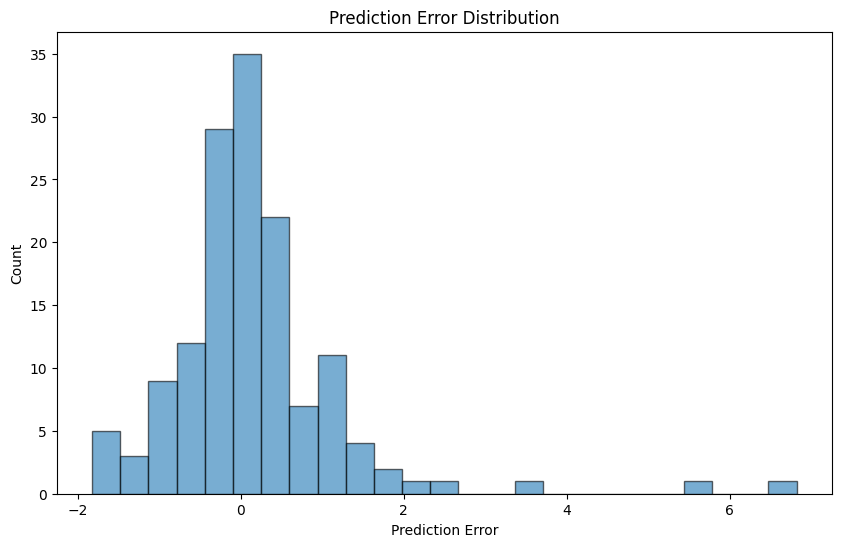

In [59]:
model_Performance(test_dataloader)